<a href="https://colab.research.google.com/github/seungmei/ESAA_23_2/blob/main/%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%97%B0%EC%B2%B4_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random

In [ ]:
train = pd.read_csv('/content/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True)

test = pd.read_csv('/content/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('/content/sample_submission.csv')

In [ ]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [ ]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), columns=enc.get_feature_names_out(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [ ]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(),
             columns=enc.get_feature_names_out(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [ ]:
train.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64

In [ ]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')

print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')


print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')


print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


In [ ]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<Axes: ylabel='Frequency'>

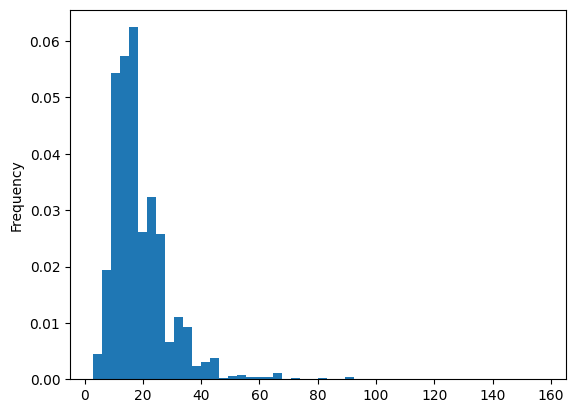

In [ ]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    lgb = LGBMClassifier(n_estimators=1000)
    evals=[(X_train, y_train), (X_valid, y_valid)]
    lgb.fit(X_train, y_train, eval_metric="logloss",
            eval_set=evals, early_stopping_rounds=30,
            verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')


====================================1============================================
[100]	training's multi_logloss: 0.757987	valid_1's multi_logloss: 0.836047
[200]	training's multi_logloss: 0.702629	valid_1's multi_logloss: 0.825665


====================================2============================================
[100]	training's multi_logloss: 0.757331	valid_1's multi_logloss: 0.832399
[200]	training's multi_logloss: 0.701883	valid_1's multi_logloss: 0.82305
[300]	training's multi_logloss: 0.661255	valid_1's multi_logloss: 0.817396


====================================3============================================
[100]	training's multi_logloss: 0.757612	valid_1's multi_logloss: 0.826979
[200]	training's multi_logloss: 0.701143	valid_1's multi_logloss: 0.81772


====================================4============================================
[100]	training's multi_logloss: 0.753565	valid_1's multi_logloss: 0.833795
[200]	training's multi_logloss: 0.698093	valid_1's multi_logloss: 0.

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [ ]:
submit.to_csv('/content/_test_submit_ensemble2.csv', index=False)

# 필요한 라이브러리 import, 데이터 불러오기

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
import catboost
from scipy.stats import randint
from sklearn.utils.fixes import loguniform

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from lightgbm import LGBMClassifier

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train=pd.read_csv('/train.csv')
test=pd.read_csv('/test.csv')
submission=pd.read_csv('/sample_submission.csv')

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

#데이터 전처리

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
#INDEX는 큰 상관이 없어 아예 제거
train=train.drop('index', axis=1)
test=test.drop('index', axis=1)

In [ ]:
#occyp_type 결측치가 8171개로 너무 많아서 아예 제거
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

In [ ]:
#FLAG_MOBIL이 다 1이므로 큰 상관이 없어 아예 제거
train=train.drop('FLAG_MOBIL', axis=1)
test=test.drop('FLAG_MOBIL', axis=1)

In [ ]:
#binary variables
#dtype이 object인 binary 변수 값들을 int 로 변경 : gender, car, reality

train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('\n')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('\n')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())

gender :
0    17697
1     8760
Name: gender, dtype: int64


Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64


Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64


<Axes: >

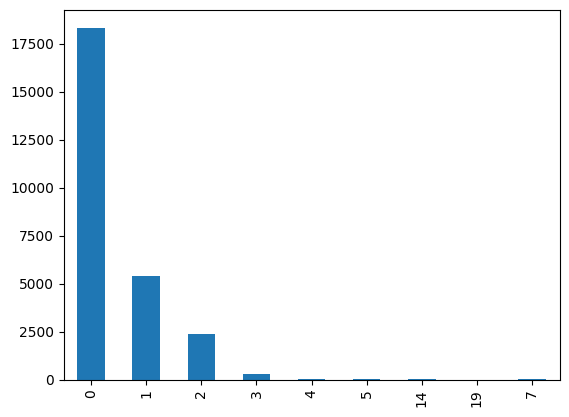

In [ ]:
#continuous variable
train['child_num'].value_counts(sort=False).plot.bar()

<Axes: xlabel='child_num'>

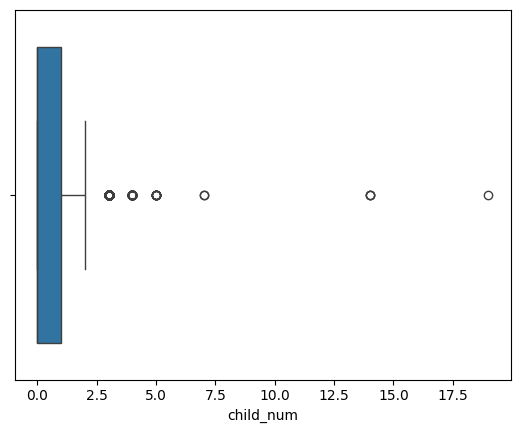

In [ ]:
sns.boxplot(x=train['child_num'])

In [ ]:
train.loc[train['child_num'] >= 3,'child_num']=3
test.loc[test['child_num']>=3, 'child_num']=3

<Axes: xlabel='child_num'>

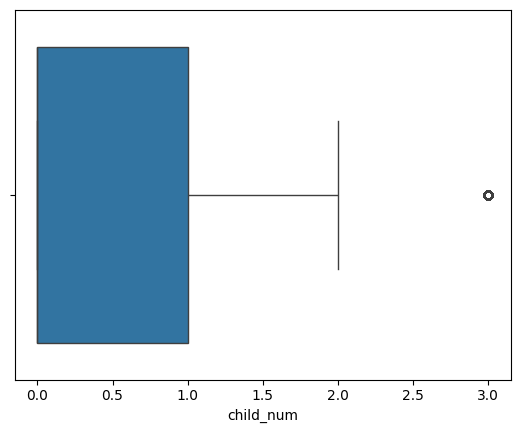

In [ ]:
sns.boxplot(x=train['child_num'])

In [ ]:
train['child_num']

0        0
1        1
2        0
3        0
4        0
        ..
26446    2
26447    1
26448    0
26449    0
26450    0
Name: child_num, Length: 26451, dtype: int64

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0,2.0


(array([1.6212e+04, 8.3300e+03, 1.5300e+03, 2.0600e+02, 1.2100e+02,
        4.4000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <BarContainer object of 10 artists>)

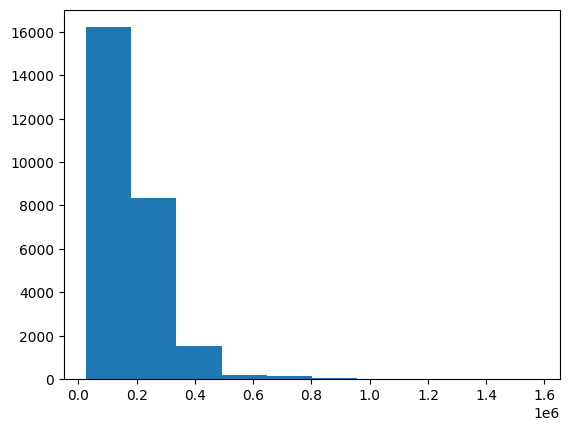

In [ ]:
plt.hist(train['income_total'])

In [ ]:
#income_total 로그 변환
train['income_total'] = np.log1p(1+train['income_total'])
test['income_total'] = np.log1p(1+test['income_total'])

(array([  84.,  341., 2788., 7265., 7716., 5505., 2362.,  308.,   77.,
          11.]),
 array([10.20366622, 10.6102763 , 11.01688639, 11.42349648, 11.83010657,
        12.23671666, 12.64332675, 13.04993683, 13.45654692, 13.86315701,
        14.2697671 ]),
 <BarContainer object of 10 artists>)

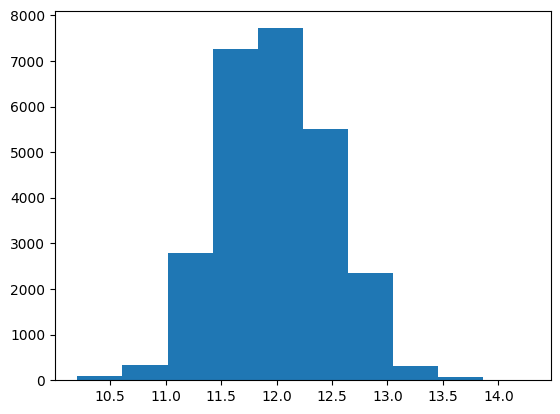

In [ ]:
plt.hist(train['income_total'])

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,0,0,1,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,1,1,1,0,13.017007,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,0,0,1,0,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,0,1,1,0,11.967193,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0,2.0


In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])

train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])

train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])

train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

# train['income_total']=label_encoder.fit_transform(train['income_total'])
# test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218505,0,1,1,2,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,0,0,1,1,12.419174,0,4,0,1,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,1,1,1,0,13.017007,4,1,1,1,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,0,0,1,0,12.218505,0,4,1,1,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,0,1,1,0,11.967193,2,1,1,1,-15037,-2105,0,0,0,2.0,-26.0,2.0


In [ ]:
res = 0
for i in train['DAYS_EMPLOYED']:
    if i >= 0:
        res += 1
print(res)
res = 0
for i in test['DAYS_EMPLOYED']:
    if i >= 0:
        res += 1
print(res)

4438
1697


In [ ]:
train['DAYS_BIRTH']=-train['DAYS_BIRTH']/365
test['DAYS_BIRTH']=-test['DAYS_BIRTH']/365

In [ ]:
for i in range(len(train['DAYS_EMPLOYED'])):
    if train['DAYS_EMPLOYED'][i] > 0:
        train['DAYS_EMPLOYED'][i]=0
    else:
      train['DAYS_EMPLOYED'][i]=-train['DAYS_EMPLOYED'][i]/365

In [ ]:
for i in range(len(test['DAYS_EMPLOYED'])):
    if test['DAYS_EMPLOYED'][i] > 0:
        test['DAYS_EMPLOYED'][i]=0
    else:
      test['DAYS_EMPLOYED'][i]=-test['DAYS_EMPLOYED'][i]/365

In [ ]:
for i in range(len(train['begin_month'])):
    if train['begin_month'][i] > 0:
        train['begin_month'][i]=0
    else:
      train['begin_month'][i]=-train['begin_month'][i]/12

In [ ]:
for i in range(len(test['begin_month'])):
    if test['begin_month'][i] > 0:
        test['begin_month'][i]=0
    else:
      test['begin_month'][i]=-test['begin_month'][i]/12

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218505,0,1,1,2,38.079452,12.901370,0,0,0,2.0,0.500000,1.0
1,0,0,1,1,12.419174,0,4,0,1,31.178082,4.219178,0,0,1,3.0,0.416667,1.0
2,1,1,1,0,13.017007,4,1,1,1,52.293151,12.147945,0,1,0,2.0,1.833333,2.0
3,0,0,1,0,12.218505,0,4,1,1,41.336986,5.731507,0,1,0,2.0,3.083333,0.0
4,0,1,1,0,11.967193,2,1,1,1,41.197260,5.767123,0,0,0,2.0,2.166667,2.0


<Axes: xlabel='family_size'>

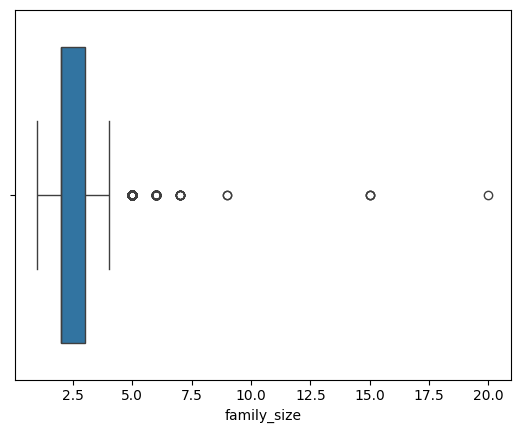

In [ ]:
sns.boxplot(x=train['family_size'])

In [ ]:
train = train[(train['family_size'] <= 10)]
train = train.reset_index(drop=True)

<Axes: xlabel='family_size'>

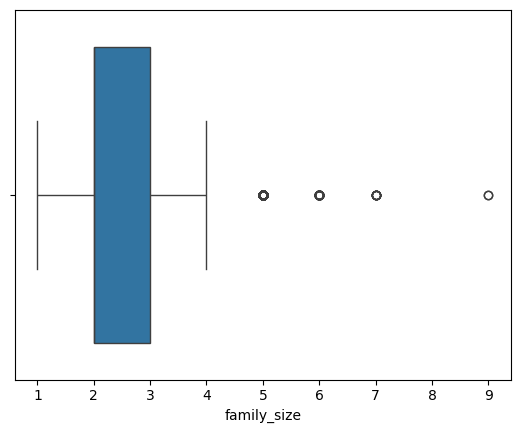

In [ ]:
sns.boxplot(x=train['family_size'])

(array([5.1090e+03, 1.4106e+04, 4.6320e+03, 2.2600e+03, 0.0000e+00,
        2.9100e+02, 4.4000e+01, 9.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

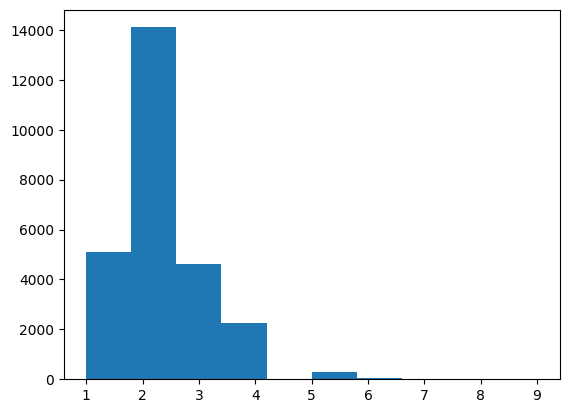

In [ ]:
plt.hist(train['family_size'])

In [ ]:
train['family_size'] = (train['family_size']-np.mean(train['family_size']))/np.std(train['family_size'])
test['family_size'] = (test['family_size']-np.mean(test['family_size']))/np.std(test['family_size'])

(array([5.1090e+03, 1.4106e+04, 4.6320e+03, 2.2600e+03, 0.0000e+00,
        2.9100e+02, 4.4000e+01, 9.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1.32756097, -0.43861096,  0.45033906,  1.33928908,  2.22823909,
         3.11718911,  4.00613913,  4.89508914,  5.78403916,  6.67298918,
         7.5619392 ]),
 <BarContainer object of 10 artists>)

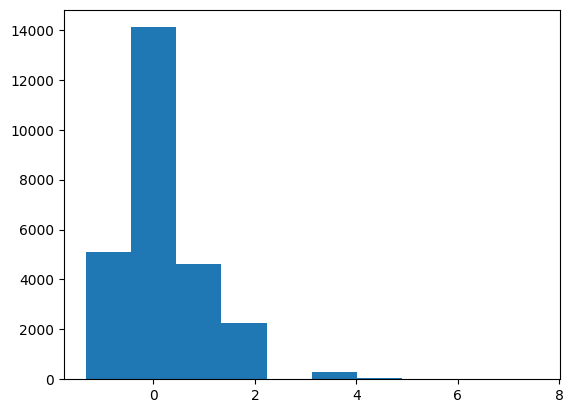

In [ ]:
plt.hist(train['family_size'])

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218505,0,1,1,2,38.079452,12.901370,0,0,0,-0.216373,0.500000,1.0
1,0,0,1,1,12.419174,0,4,0,1,31.178082,4.219178,0,0,1,0.894814,0.416667,1.0
2,1,1,1,0,13.017007,4,1,1,1,52.293151,12.147945,0,1,0,-0.216373,1.833333,2.0
3,0,0,1,0,12.218505,0,4,1,1,41.336986,5.731507,0,1,0,-0.216373,3.083333,0.0
4,0,1,1,0,11.967193,2,1,1,1,41.197260,5.767123,0,0,0,-0.216373,2.166667,2.0


#test_x,test_y, train_x, train_y 분리

In [ ]:
train_x = train.drop("credit", axis = 1)
train_x.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,0,0,0,0,12.218505,0,1,1,2,38.079452,12.901370,0,0,0,-0.216373,0.500000
1,0,0,1,1,12.419174,0,4,0,1,31.178082,4.219178,0,0,1,0.894814,0.416667
2,1,1,1,0,13.017007,4,1,1,1,52.293151,12.147945,0,1,0,-0.216373,1.833333
3,0,0,1,0,12.218505,0,4,1,1,41.336986,5.731507,0,1,0,-0.216373,3.083333
4,0,1,1,0,11.967193,2,1,1,1,41.197260,5.767123,0,0,0,-0.216373,2.166667


In [ ]:
train_y = train[['credit']]
train_y.head()

,credit
0,1.0
1,1.0
2,2.0
3,0.0
4,2.0


In [ ]:
test_x = test
test_x.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,1,1,0,0,11.630726,1,4,0,1,60.246575,0.000000,0,1,0,-0.225667,5.000000
1,0,0,1,0,11.813045,2,1,1,1,51.956164,23.756164,0,1,0,-0.225667,3.000000
2,0,0,1,0,11.147267,4,4,1,1,43.526027,0.594521,1,1,0,-0.225667,3.333333
3,1,1,0,0,11.630726,0,4,1,1,52.794521,6.934247,1,0,0,-0.225667,3.416667
4,0,1,1,0,12.323865,2,1,1,1,48.827397,25.712329,1,0,0,-0.225667,0.666667


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19839, 16)
(19839, 1)
Validation set: 
(6614, 16)
(6614, 1)


#XGBoost(0.7080753493)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
clf_xgb=xgb.XGBClassifier(random_state=42)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

##하이퍼 파라미터 설정 안 한 경우(0.7218180547)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf_xgb)

FOLD 0 : logloss:0.7468684256043667
FOLD 1 : logloss:0.757068270846105
FOLD 2 : logloss:0.7571206187507145
FOLD 3 : logloss:0.7394722084655787
FOLD 4 : logloss:0.7429340419347417
Mean:0.7486927131203013


In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('baseline_submission2.csv', index=False)

##하이퍼 파라미터 설정 한 경우(0.7080753493)

In [ ]:
from sklearn.model_selection import GridSearchCV

params={'max_depth':[5,7,8],'learning_rate':[0.01,0.25,0.5], 'gamma':[0.5,0.25,0.01],'reg_lambda':[0.01,0.25,0.5],'scale_pos_weight':[1,2]}

grid_cv=GridSearchCV(clf_xgb,param_grid=params, scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
GridSearchCV 최고 평균 정확도 수치: 0.7031
GridSearchCV 최적 하이퍼 파라미터:  {'gamma': 0.01, 'learning_rate': 0.25, 'max_depth': 8, 'reg_lambda': 0.25, 'scale_pos_weight': 1}


In [ ]:
best_df_clf=grid_cv.best_estimator_

In [ ]:
y_pred=best_df_clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7591402529739408


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(best_df_clf)

FOLD 0 : logloss:0.7419001961300228
FOLD 1 : logloss:0.7612446720400038
FOLD 2 : logloss:0.7571638020085925
FOLD 3 : logloss:0.7352405461239014
FOLD 4 : logloss:0.7474464810198909
Mean:0.7485991394644822


In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.045959,0.061073,0.892968
1,26458,0.155935,0.135337,0.708728
2,26459,0.028158,0.080230,0.891612
3,26460,0.092199,0.117099,0.790702
4,26461,0.104763,0.126481,0.768756
...,...,...,...,...
9995,36452,0.095792,0.186431,0.717777
9996,36453,0.198098,0.349244,0.452658
9997,36454,0.022618,0.042182,0.935200
9998,36455,0.085464,0.253376,0.661160


In [ ]:
submission.to_csv('baseline_submission7.csv', index=False)

#LightGBM(0.7400477747)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from lightgbm import LGBMClassifier

##하이퍼 파라미터 설정 한 경우(0.7400477747)

In [ ]:
  # Step 1: Define parameter grid for hyperparameter tuning
param_grid = {
      'learning_rate': [0.1, 0.01],
      'n_estimators': [50, 100, 150],
      'max_depth': [4, 6],
      'colsample_bytree': [0.7, 0.8, 0.9],
      'subsample': [0.7, 0.8, 0.9],
      'min_child_samples': [1, 5, 10]
  }

  # Step 2: Initialize LGBMRegressor estimattor
estimator = LGBMClassifier(random_state=42)

  # Step 3: Initalise Grid Search with 3-fold cross validation and fit model
model = GridSearchCV(estimator=estimator,
                       param_grid=param_grid,
                       cv=3,
                       n_jobs=-1,
                       scoring='neg_root_mean_squared_error')
model.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(model.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', model.best_params_)
  # Step 4: Print best parameters
best_params = model.best_estimator_
print(best_params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 19839, number of used features: 16
[LightGBM] [Info] Start training from score -2.105536
[LightGBM] [Info] Start training from score -1.440087
[LightGBM] [Info] Start training from score -0.444238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
y_pred=best_params.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
log_loss: 0.7615708503964542


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(best_params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 21162, number of used features: 16
[LightGBM] [Info] Start training from score -2.105193
[LightGBM] [Info] Start training from score -1.440173
[LightGBM] [Info] Start training from score -0.444272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('baseline_submission4.csv', index=False)

#catboost(0.7363803863)

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218505,0,1,1,2,38.079452,12.901370,0,0,0,-0.216373,0.500000,1.0
1,0,0,1,1,12.419174,0,4,0,1,31.178082,4.219178,0,0,1,0.894814,0.416667,1.0
2,1,1,1,0,13.017007,4,1,1,1,52.293151,12.147945,0,1,0,-0.216373,1.833333,2.0
3,0,0,1,0,12.218505,0,4,1,1,41.336986,5.731507,0,1,0,-0.216373,3.083333,0.0
4,0,1,1,0,11.967193,2,1,1,1,41.197260,5.767123,0,0,0,-0.216373,2.166667,2.0


In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0347429	test: 1.0329836	best: 1.0329836 (0)	total: 165ms	remaining: 2m 44s
100:	learn: 0.7862706	test: 0.7844309	best: 0.7844309 (100)	total: 13.9s	remaining: 2m 4s
200:	learn: 0.7544720	test: 0.7699774	best: 0.7699774 (200)	total: 24.2s	remaining: 1m 36s
300:	learn: 0.7285977	test: 0.7604238	best: 0.7602088 (298)	total: 32.6s	remaining: 1m 15s
400:	learn: 0.7078281	test: 0.7532003	best: 0.7531447 (398)	total: 42.8s	remaining: 1m 3s
500:	learn: 0.6881709	test: 0.7476263	best: 0.7476180 (499)	total: 53.2s	remaining: 53s
600:	learn: 0.6692494	test: 0.7427675	best: 0.7427675 (600)	total: 1m 3s	remaining: 42.1s
700:	learn: 0.6528746	test: 0.7377277	best: 0.7377277 (700)	total: 1m 12s	remaining: 30.8s
800:	learn: 0.6377743	test: 0.7350400	best: 0.7348275 (793)	total: 1m 22s	remaining: 20.5s
900:	learn: 0.6230847	test: 0.7312535	best: 0.7311332 (898)	total: 1m 32s	remaining: 10.2s
999:	learn: 0.6095766	tes

In [ ]:
submission.iloc[:, 1:] = cat_pred_test
submission

,index,0,1,2
0,26457,0.056557,0.095775,0.847668
1,26458,0.175794,0.117298,0.706908
2,26459,0.087324,0.099727,0.812948
3,26460,0.138835,0.130158,0.731007
4,26461,0.105277,0.205662,0.689061
...,...,...,...,...
9995,36452,0.148482,0.206048,0.645470
9996,36453,0.107456,0.310218,0.582326
9997,36454,0.022857,0.072782,0.904361
9998,36455,0.089875,0.186351,0.723773


In [ ]:
submission.to_csv('submission_Final_catboost_new.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train = pd.read_csv('/content/gdrive/MyDrive/ESAA/project/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/ESAA/project/test.csv')
submission = pd.read_csv('/content/gdrive/MyDrive/ESAA/project/sample_submission.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#train = pd.read_csv('/content/train.csv')
#test = pd.read_csv('/content/test.csv')
#submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


In [ ]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

##### describe(): 칼럼별 숫자형 데이터값의 n-percentile 분포도, 평균값, 최댓값, 최솟값을 나타냄. 숫자형 칼럼의 분포도만 조사

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
#결측치 확인
train.isnull()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
26453,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
26454,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
26455,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
train[(train['occyp_type'].isnull())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
8,8,M,Y,Y,1,180000.0,Commercial associate,Higher education,Married,House / apartment,-15131,-1466,1,0,0,1,NaN,3.0,-38.0,2.0
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0
19,19,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-13727,-6031,1,0,0,0,NaN,2.0,-7.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,NaN,2.0,-57.0,2.0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,NaN,1.0,-43.0,2.0
26443,26443,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22286,365243,1,0,0,0,NaN,1.0,-21.0,1.0
26449,26449,F,N,N,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-10498,-2418,1,1,1,0,NaN,2.0,-2.0,1.0


In [ ]:
type(train)

pandas.core.frame.DataFrame

# **시각화 & 전처리**

## 0. 결측치 제거

In [ ]:
#occyp에 결측가 너무 많아 아예 칼럼 제거
train = train.drop('occyp_type', axis=1)
test = test.drop('occyp_type', axis=1)

train = train.drop('index', axis=1)
test = test.drop('index', axis=1)

## 1. Binary variables

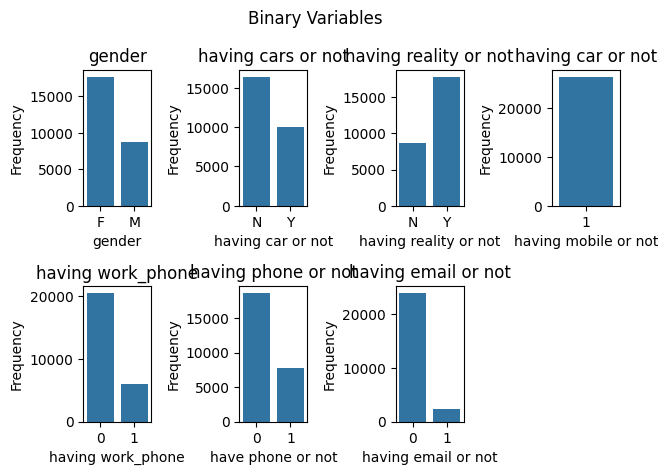

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(2,4,1)
ax1 = sns.countplot(x='gender', data=train)
ax1.set_title('gender')
ax1.set_xlabel('gender')
ax1.set_ylabel('Frequency')

ax2 = fig1.add_subplot(2,4,2)
ax2 = sns.countplot(x='car', data=train)
ax2.set_title('having cars or not')
ax2.set_xlabel('having car or not')
ax2.set_ylabel('Frequency')

ax3 = fig1.add_subplot(2,4,3)
ax3 = sns.countplot(x='reality', data=train)
ax3.set_title('having reality or not')
ax3.set_xlabel('having reality or not')
ax3.set_ylabel('Frequency')

ax4 = fig1.add_subplot(2,4,4)
ax4 = sns.countplot(x='FLAG_MOBIL', data=train)
ax4.set_title('having car or not')
ax4.set_xlabel('having mobile or not')
ax4.set_ylabel('Frequency')

ax5 = fig1.add_subplot(2,4,5)
ax5 = sns.countplot(x='work_phone', data=train)
ax5.set_title('having work_phone')
ax5.set_xlabel('having work_phone')
ax5.set_ylabel('Frequency')

ax6 = fig1.add_subplot(2,4,6)
ax6 = sns.countplot(x='phone', data=train)
ax6.set_title('having phone or not')
ax6.set_xlabel('have phone or not')
ax6.set_ylabel('Frequency')

ax7 = fig1.add_subplot(2,4,7)
ax7 = sns.countplot(x='email', data=train)
ax7.set_title('having email or not')
ax7.set_xlabel('having email or not')
ax7.set_ylabel('Frequency')

fig1.suptitle("Binary Variables")

fig1.tight_layout()

In [ ]:
gender_counts = train['gender'].value_counts()
print(gender_counts)
print('--------------------------------')

car_counts = train['car'].value_counts()
print(car_counts)
print('--------------------------------')

reality_counts = train['reality'].value_counts()
print(reality_counts)
print('--------------------------------')

MOBIL_counts = train['FLAG_MOBIL'].value_counts()
print(MOBIL_counts)
print('--------------------------------')

workphone_counts = train['work_phone'].value_counts()
print(workphone_counts)
print('--------------------------------')

phone_counts = train['phone'].value_counts()
print(phone_counts)
print('--------------------------------')

email_counts = train['email'].value_counts()
print(email_counts)
print('--------------------------------')

F    17697
M     8760
Name: gender, dtype: int64
--------------------------------
N    16410
Y    10047
Name: car, dtype: int64
--------------------------------
Y    17830
N     8627
Name: reality, dtype: int64
--------------------------------
1    26457
Name: FLAG_MOBIL, dtype: int64
--------------------------------
0    20511
1     5946
Name: work_phone, dtype: int64
--------------------------------
0    18672
1     7785
Name: phone, dtype: int64
--------------------------------
0    24042
1     2415
Name: email, dtype: int64
--------------------------------


전처리

In [ ]:
#FLAG_MOBIL 칼럼 의미 없어 제거
train = train.drop('FLAG_MOBIL', axis=1)
test = test.drop('FLAG_MOBIL', axis=1)

In [ ]:
#변수를 원핫인코딩
train = pd.get_dummies(train, columns = ['gender', 'car', 'reality','work_phone','phone','email'], drop_first=True)
train

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,gender_M,car_Y,reality_Y,work_phone_1,phone_1,email_1
0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,2.0,-6.0,1.0,0,0,0,0,0,0
1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,3.0,-5.0,1.0,0,0,1,0,0,1
2,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,2.0,-22.0,2.0,1,1,1,0,1,0
3,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,2.0,-37.0,0.0,0,0,1,0,1,0
4,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,2.0,-26.0,2.0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,4.0,-2.0,1.0,0,0,0,0,0,0
26453,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,2.0,-47.0,2.0,0,0,1,0,0,0
26454,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,2.0,-25.0,2.0,0,1,0,0,0,0
26455,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1.0,-59.0,2.0,1,0,1,0,0,0


In [ ]:
test = pd.get_dummies(test, columns = ['gender', 'car', 'reality','work_phone','phone','email'], drop_first=True)
test

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,gender_M,car_Y,reality_Y,work_phone_1,phone_1,email_1
0,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,2.0,-60.0,1,1,0,0,1,0
1,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,2.0,-36.0,0,0,1,0,1,0
2,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,2.0,-40.0,0,0,1,1,1,0
3,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,2.0,-41.0,1,1,0,1,0,0
4,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,2.0,-8.0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,2.0,-19.0,0,1,1,1,1,0
9996,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,2.0,-34.0,1,1,1,1,0,0
9997,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,2.0,-55.0,0,0,1,0,0,0
9998,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,2.0,-33.0,0,1,0,0,1,0


## 2. categorical variables

-시각화

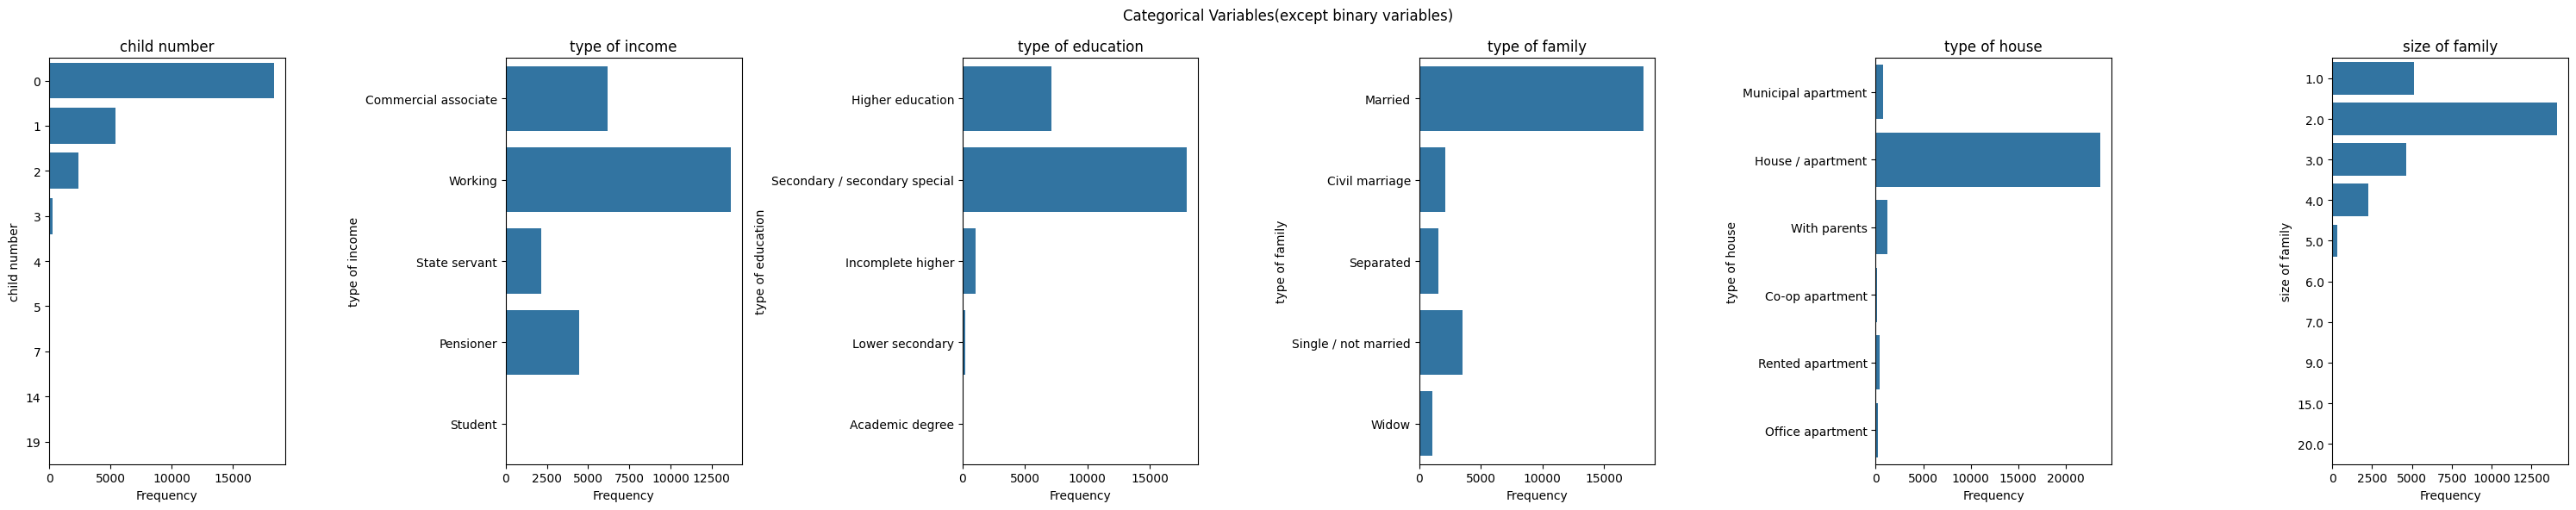

In [ ]:
fig2, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(figsize=(30,6), nrows=1, ncols=6)

sns.countplot(y=train['child_num'], ax=ax1)
ax1.set_title('child number')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('child number')

sns.countplot(y=train['income_type'], ax=ax2)
ax2.set_title('type of income')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('type of income')

sns.countplot(y=train['edu_type'], ax=ax3)
ax3.set_title('type of education')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('type of education')

sns.countplot(y=train['family_type'], ax=ax4)
ax4.set_title('type of family')
ax4.set_xlabel('Frequency')
ax4.set_ylabel('type of family')

sns.countplot(y=train['house_type'], ax=ax5)
ax5.set_title('type of house')
ax5.set_xlabel('Frequency')
ax5.set_ylabel('type of house')

sns.countplot(y=train['family_size'], ax=ax6)
ax6.set_title('size of family')
ax6.set_xlabel('Frequency')
ax6.set_ylabel('size of family')

#결측치가 많아서 우선 제거함.
#sns.countplot(y=train['occyp_type'], ax=ax6)
#ax7.set_title('type of occupation')
#ax7.set_xlabel('Frequency')
#ax.set_ylabel('type of occupation')

fig2.suptitle("Categorical Variables(except binary variables)")

fig2.tight_layout()

In [ ]:
child_counts = train['child_num'].value_counts()
print(child_counts)
print('--------------------------------')

income_counts = train['income_type'].value_counts()
print(income_counts)
print('--------------------------------')

edu_counts = train['edu_type'].value_counts()
print(edu_counts)
print('--------------------------------')

family_counts = train['family_type'].value_counts()
print(family_counts)
print('--------------------------------')

workphone_counts = train['house_type'].value_counts()
print(workphone_counts)
print('--------------------------------')

f_size_counts = train['family_size'].value_counts()
print(f_size_counts)
print('--------------------------------')

#occyp_counts = train['occyp_type'].value_counts()
#print(occyp_counts)
#print('--------------------------------')

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64
--------------------------------
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64
--------------------------------
Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64
--------------------------------
Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64
--------------------------------
House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         1

-전처리

In [ ]:
#child_num이 3 이상은 수가 적기 때문에 2이상의 수를 2로 바꿈
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

#family_size이 5 이상은 수가 적기 때문에 4이상의 수를 4로 바꿈
train.loc[train['family_size'] >= 4,'family_size']=4
test.loc[test['family_size']>=4, 'family_size']=4

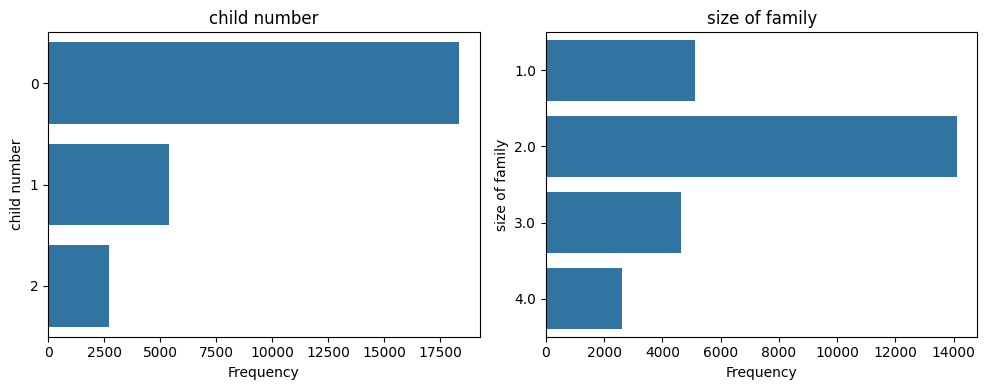

In [ ]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

sns.countplot(y=train['child_num'], ax=ax1)
ax1.set_title('child number')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('child number')

sns.countplot(y=train['family_size'], ax=ax2)
ax2.set_title('size of family')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('size of family')

fig.tight_layout()

In [ ]:
#원핫 인코딩
train = pd.get_dummies(train, columns = ['income_type', 'edu_type', 'family_type','house_type'], drop_first=True)
train

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,gender_M,car_Y,reality_Y,...,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,202500.0,-13899,-4709,2.0,-6.0,1.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1,247500.0,-11380,-1540,3.0,-5.0,1.0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,450000.0,-19087,-4434,2.0,-22.0,2.0,1,1,1,...,0,1,0,0,0,1,0,0,0,0
3,0,202500.0,-15088,-2092,2.0,-37.0,0.0,0,0,1,...,1,1,0,0,0,1,0,0,0,0
4,0,157500.0,-15037,-2105,2.0,-26.0,2.0,0,1,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,-12079,-1984,4.0,-2.0,1.0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
26453,1,180000.0,-15291,-2475,2.0,-47.0,2.0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
26454,0,292500.0,-10082,-2015,2.0,-25.0,2.0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
26455,0,171000.0,-10145,-107,1.0,-59.0,2.0,1,0,1,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
test = pd.get_dummies(test, columns = ['income_type', 'edu_type', 'family_type','house_type'], drop_first=True)
test

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,gender_M,car_Y,reality_Y,work_phone_1,...,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,112500.0,-21990,365243,2.0,-60.0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,135000.0,-18964,-8671,2.0,-36.0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,0,69372.0,-15887,-217,2.0,-40.0,0,0,1,1,...,1,1,0,0,0,1,0,0,0,0
3,0,112500.0,-19270,-2531,2.0,-41.0,1,1,0,1,...,1,1,0,0,0,1,0,0,0,0
4,0,225000.0,-17822,-9385,2.0,-8.0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,-18593,-5434,2.0,-19.0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,0
9996,0,202500.0,-10886,-1315,2.0,-34.0,1,1,1,1,...,1,0,0,0,0,1,0,0,0,0
9997,0,292500.0,-21016,-14018,2.0,-55.0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,0
9998,0,180000.0,-16541,-1085,2.0,-33.0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,0


## 3.continuous variable

-시각화

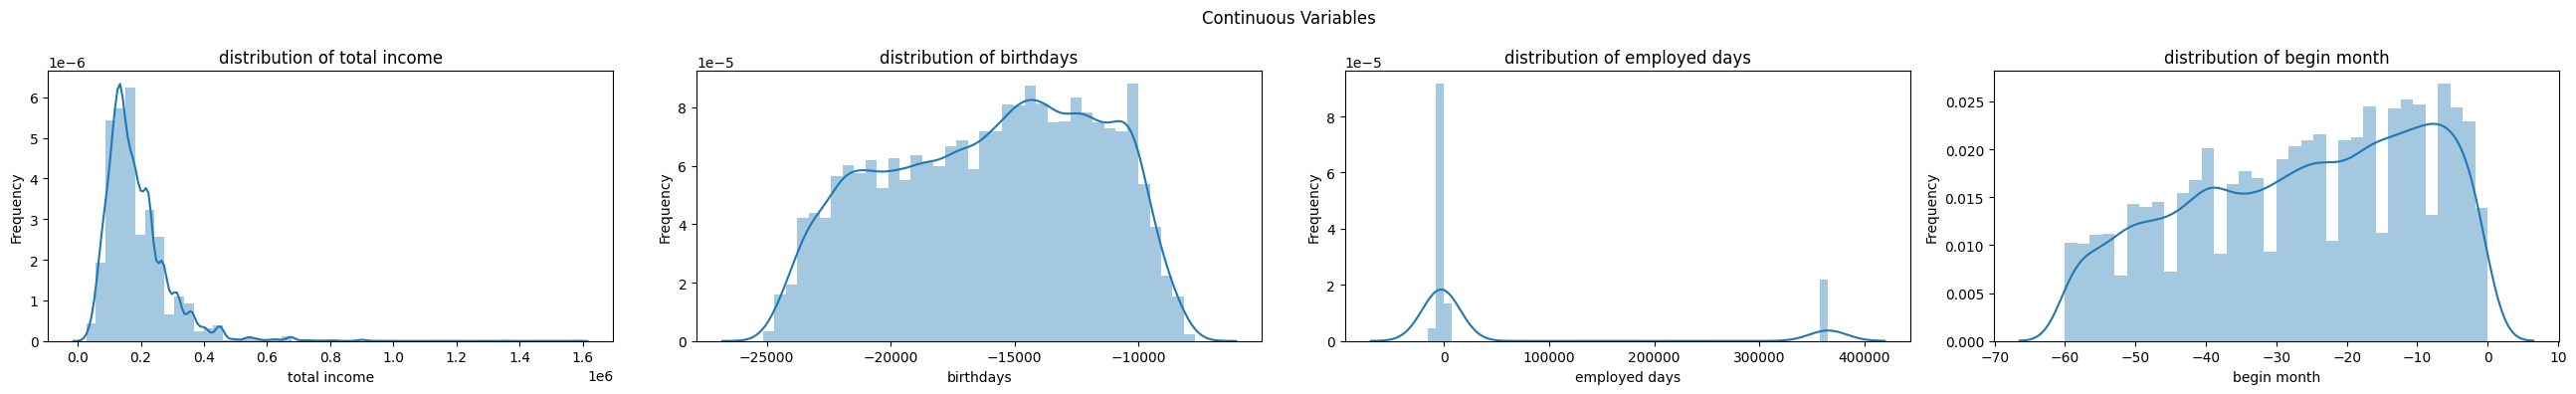

In [ ]:
#income_total, DAYS_BIRTH, DAYS_EMPLOYED, begin_month
fig3, (ax1,ax2,ax3,ax4) = plt.subplots(figsize=(26,4), nrows=1, ncols=4)

sns.distplot(x=train['income_total'], ax=ax1)
ax1.set_title('distribution of total income')
ax1.set_xlabel('total income')
ax1.set_ylabel('Frequency')

sns.distplot(x=train['DAYS_BIRTH'], ax=ax2)
ax2.set_title('distribution of birthdays')
ax2.set_xlabel('birthdays')
ax2.set_ylabel('Frequency')

sns.distplot(x=train['DAYS_EMPLOYED'], ax=ax3)
ax3.set_title('distribution of employed days')
ax3.set_xlabel('employed days')
ax3.set_ylabel('Frequency')

sns.distplot(x=train['begin_month'], ax=ax4)
ax4.set_title('distribution of begin month')
ax4.set_xlabel('begin month')
ax4.set_ylabel('Frequency')

fig3.suptitle("Continuous Variables")

fig3.tight_layout()

-전처리

In [ ]:
#income_total
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000

print(train['income_total'].value_counts(bins=10,sort=False))

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


In [ ]:
#income_total 로그변환
train['income_total'] = train['income_total'].apply(np.log1p)

In [ ]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
#DAYS_BIRTH, DAYS_EMPLOYED, begin_month
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True)

    label_encoder = preprocessing.LabelEncoder()
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
make_bin('DAYS_BIRTH', n=10)   #DAYS_BIRTH 구간 10개
make_bin('DAYS_EMPLOYED', n=6)  #DAYS_EMPLOYED 구간 6개
make_bin('begin_month', n=4)  #begin_month 구간 4개

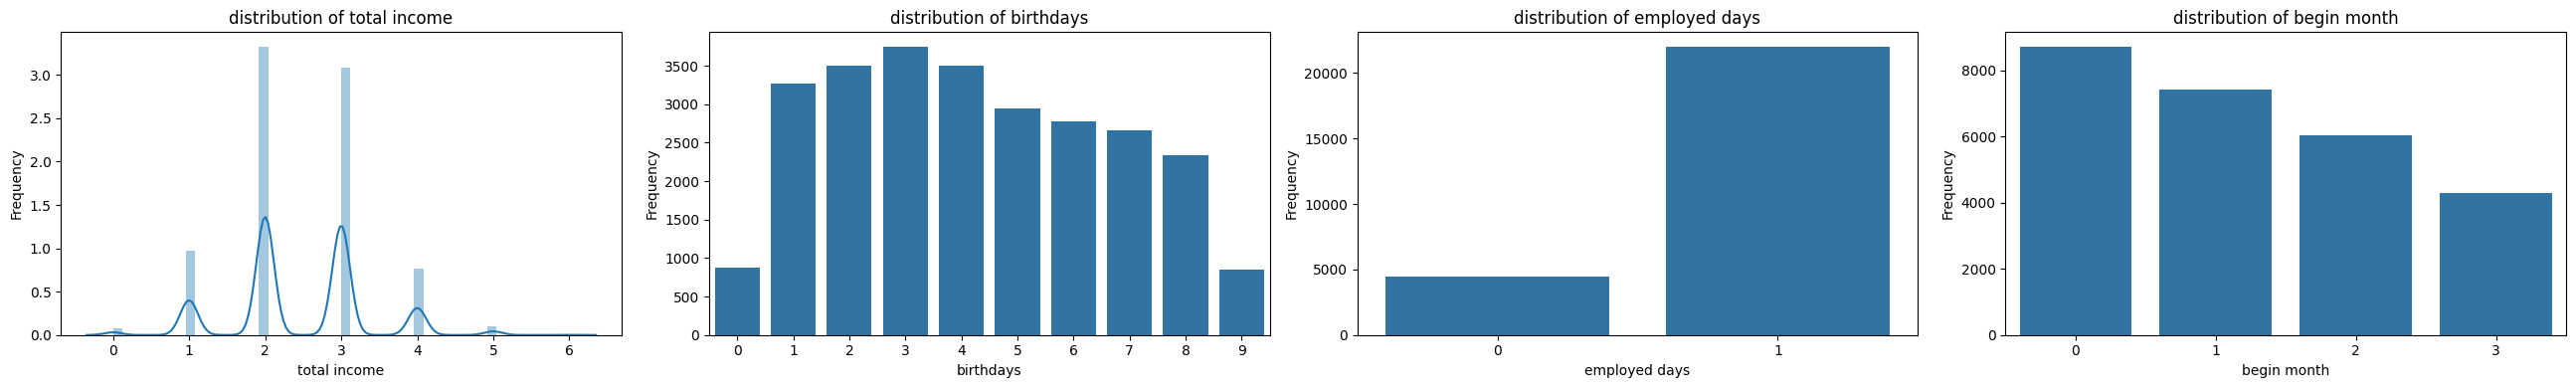

In [ ]:
#구간화된 변수들의 그래프와 값 확인
fig4, (ax1, ax2,ax3,ax4) = plt.subplots(figsize=(26,4), nrows=1, ncols=4)

sns.distplot(x=train['income_total'], ax=ax1)
ax1.set_title('distribution of total income')
ax1.set_xlabel('total income')
ax1.set_ylabel('Frequency')

sns.countplot(x=train['DAYS_BIRTH'], ax=ax2)
ax2.set_title('distribution of birthdays')
ax2.set_xlabel('birthdays')
ax2.set_ylabel('Frequency')

sns.countplot(x=train['DAYS_EMPLOYED'], ax=ax3)
ax3.set_title('distribution of employed days')
ax3.set_xlabel('employed days')
ax3.set_ylabel('Frequency')

sns.countplot(x=train['begin_month'], ax=ax4)
ax4.set_title('distribution of begin month')
ax4.set_xlabel('begin month')
ax4.set_ylabel('Frequency')

fig4.tight_layout()

In [ ]:
print(train['income_total'].value_counts(sort=False))
print('--------------------------------------------------------------')
print(train['DAYS_BIRTH'].value_counts(sort=False))
print('--------------------------------------------------------------')
print(train['DAYS_EMPLOYED'].value_counts(sort=False))
print('--------------------------------------------------------------')
print(train['begin_month'].value_counts(sort=False))
print('--------------------------------------------------------------')

3     9799
4     2416
2    10563
5      324
1     3098
0      239
6       18
Name: income_total, dtype: int64
--------------------------------------------------------------
3    3748
2    3498
6    2773
4    3497
5    2941
1    3271
8    2340
0     876
7    2665
9     848
Name: DAYS_BIRTH, dtype: int64
--------------------------------------------------------------
1    22019
0     4438
Name: DAYS_EMPLOYED, dtype: int64
--------------------------------------------------------------
0    8712
1    7418
2    6025
3    4302
Name: begin_month, dtype: int64
--------------------------------------------------------------


# 모델링

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 29) (26457, 1) (10000, 29)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn import svm

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

# gradient boosting - 하이퍼 파라미터 적용x

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf1 = GradientBoostingClassifier()
gb_clf1.fit(X_train,y_train)
y_pred = gb_clf1.predict(X_val)

In [ ]:
my_submission = run_kfold(gb_clf1)

FOLD 0 : logloss:0.8584815496481405
FOLD 1 : logloss:0.856417240540667
FOLD 2 : logloss:0.8581753346636891
FOLD 3 : logloss:0.8573118430035928
FOLD 4 : logloss:0.8587914778199179
Mean:0.8578354891352014


In [ ]:
my_submission

array([[0.12561904, 0.08101457, 0.79336639],
       [0.1560342 , 0.09133485, 0.75263094],
       [0.12782755, 0.1367675 , 0.73540495],
       ...,
       [0.11707382, 0.10556413, 0.77736206],
       [0.13762491, 0.0910974 , 0.77127769],
       [0.1415124 , 0.29369984, 0.56478776]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.125619,0.081015,0.793366
1,26458,0.156034,0.091335,0.752631
2,26459,0.127828,0.136768,0.735405
3,26460,0.151840,0.099898,0.748262
4,26461,0.278869,0.229733,0.491399
...,...,...,...,...
9995,36452,0.151462,0.171451,0.677087
9996,36453,0.095434,0.168035,0.736531
9997,36454,0.117074,0.105564,0.777362
9998,36455,0.137625,0.091097,0.771278


In [ ]:
submission.to_csv('gradientboosting1_submission.csv', index=False)

#gradient boostin - 하이퍼 파라미터 적용

In [ ]:
#최적의 파라미터 값 찾기
from sklearn.model_selection import GridSearchCV
gb_clf = GradientBoostingClassifier()
params = {
    'learning_rate': [0.01, 0.05, 0.5],
    'n_estimators':[100,400],
    'subsample': [0.5, 0.75, 1]
}
gridcv = GridSearchCV(gb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train)
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

GridSearchCV 최적 파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0.5}


In [ ]:
#모델 정의 및 학습
gb_clf2 = GradientBoostingClassifier(
    learning_rate = 0.01,
    n_estimators = 400,
    subsample = 0.5
    )

gb_clf2.fit(X_train, y_train)

#학습된 모델로 예측 데이터 생성
pred = gb_clf2.predict(X_val)

In [ ]:
my_submission = run_kfold(gb_clf2)

FOLD 0 : logloss:0.862303176430587
FOLD 1 : logloss:0.858264573004181
FOLD 2 : logloss:0.8605200637849176
FOLD 3 : logloss:0.8609708182365636
FOLD 4 : logloss:0.8602731877563191
Mean:0.8604663638425137


In [ ]:
my_submission

array([[0.12476045, 0.11512317, 0.76011638],
       [0.14272848, 0.12811575, 0.72915577],
       [0.13036951, 0.13889072, 0.73073977],
       ...,
       [0.11075975, 0.1230213 , 0.76621896],
       [0.11868708, 0.11569402, 0.7656189 ],
       [0.14242674, 0.30805937, 0.54951389]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.124760,0.115123,0.760116
1,26458,0.142728,0.128116,0.729156
2,26459,0.130370,0.138891,0.730740
3,26460,0.125800,0.123450,0.750750
4,26461,0.204219,0.258440,0.537341
...,...,...,...,...
9995,36452,0.146273,0.150132,0.703595
9996,36453,0.103800,0.173165,0.723036
9997,36454,0.110760,0.123021,0.766219
9998,36455,0.118687,0.115694,0.765619


In [ ]:
submission.to_csv('gradientboosting2_submission.csv', index=False)

#randomforest - 하이퍼파라미터 적용x

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier()
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_val)

In [ ]:
my_submission = run_kfold(clf1)

FOLD 0 : logloss:1.030065196061488
FOLD 1 : logloss:1.0011355686204708
FOLD 2 : logloss:1.0371392879804173
FOLD 3 : logloss:0.9695647489204413
FOLD 4 : logloss:1.0122428548089908
Mean:1.0100295312783616


In [ ]:
my_submission

array([[0.198, 0.2  , 0.602],
       [0.304, 0.152, 0.544],
       [0.232, 0.224, 0.544],
       ...,
       [0.146, 0.14 , 0.714],
       [0.212, 0.294, 0.494],
       [0.126, 0.378, 0.496]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.198,0.200,0.602
1,26458,0.304,0.152,0.544
2,26459,0.232,0.224,0.544
3,26460,0.162,0.238,0.600
4,26461,0.184,0.332,0.484
...,...,...,...,...
9995,36452,0.208,0.248,0.544
9996,36453,0.122,0.374,0.504
9997,36454,0.146,0.140,0.714
9998,36455,0.212,0.294,0.494


In [ ]:
submission.to_csv('randomforest1_submission.csv', index=False)

#randomforest - 하이퍼파라미터 적용

In [ ]:
#최적의 파라미터 값 찾기
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
params = {
    'n_estimators':[100,400,800],
    'max_depth':[6,8,10],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}
gridcv = GridSearchCV(clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train)
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

GridSearchCV 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [ ]:
#모델 정의 및 학습
clf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth = 10,
    min_samples_leaf = 8,
    min_samples_split = 8
    )
clf2.fit(X_train, y_train)

#학습된 모델로 예측 데이터 생성
pred = clf2.predict(X_val)

In [ ]:
my_submission = run_kfold(clf2)

FOLD 0 : logloss:0.854957405855635
FOLD 1 : logloss:0.852331284242794
FOLD 2 : logloss:0.8527776124398777
FOLD 3 : logloss:0.8524138855042569
FOLD 4 : logloss:0.8526520802877029
Mean:0.8530264536660533


In [ ]:
my_submission

array([[0.11758217, 0.20410276, 0.67831507],
       [0.1376902 , 0.17179484, 0.69051496],
       [0.12754303, 0.22652995, 0.64592702],
       ...,
       [0.10670836, 0.19477329, 0.69851835],
       [0.13223432, 0.21044457, 0.65732111],
       [0.10717828, 0.31867457, 0.57414715]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.117582,0.204103,0.678315
1,26458,0.137690,0.171795,0.690515
2,26459,0.127543,0.226530,0.645927
3,26460,0.118991,0.199042,0.681967
4,26461,0.169672,0.274180,0.556147
...,...,...,...,...
9995,36452,0.136105,0.221731,0.642164
9996,36453,0.100548,0.270167,0.629284
9997,36454,0.106708,0.194773,0.698518
9998,36455,0.132234,0.210445,0.657321


In [ ]:
submission.to_csv('randomforest2_submission.csv', index=False)

# **라이브러리 불러오기**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/dataset/credit_card/open')

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/credit_card/open/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/credit_card/open/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/credit_card/open/sample_submission.csv')

# **[데이터 살펴보기]**

In [ ]:
train.head()
# income_total: 연간소득
# income_type: 소득분류 - commercial associate, working, state servant, persioner, student
# edu_type: 교육 수준 - higher, secondary ...
# family_type: 결혼 여부
# house_type: 생활방식 - municipal apartment, house
# days_employed: 업무 시작일. 데이터 수집 당시(0)부터 역으로 셈. -1은 수집일 하루전부터 일을 시작함.
# flag_mobil: 핸드폰 소유 여부
# occyp_type: 직업 유형
# begin_month: 신용카드 발급 월
## credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도(낮을수록 높은 신용의 사용자)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [ ]:
train.shape

(26457, 20)

In [ ]:
test.shape

(10000, 19)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# **[데이터 전처리]**

**(주의) train data에 해준 그대로 test data 전처리**

### 결측치 제거

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


### family_size가 7을 넘어가면 이상치이므로 데이터 삭제

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

### FLAG_MOBIL의 min과 max가 모두 1이므로 표본 모두가 휴대전화를 소지함. FLAG_MOBIL과 index는 제거


In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### train 데이터의 전체 표본 개수 2.6만 중에 0.8만의 occyp_type이 null값이므로 drop

In [ ]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

### DAYS_EMPLOYED에서 양수인 데이터는 현재 무직자로 판단. 0처리.

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [ ]:
train['income_type'].value_counts()

Working                 13639
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [ ]:
train['family_type'].value_counts()
# civil marriage: 종교 의식을 하지 않은 민간 결혼

Married                 18194
Single / not married     3495
Civil marriage           2123
Separated                1536
Widow                    1103
Name: family_type, dtype: int64

In [ ]:
train['house_type'].value_counts()

House / apartment      23647
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

### 원-핫 인코딩

In [ ]:
#범주형 변수는 기계학습을 시킬 수 없기 때문에 범주형 변수들을 0과 1의 변수로 바꿔주기. 원핫인코딩 하기.
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')

print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')


print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')


print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17694
1     8757
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16407
1    10044
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17826
0     8625
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18669
1     7782
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24036
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20508
1     5943
Name: work_phone, dtype: int64
--------------


### income_total을 구간별로 나누기

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

(2.544, 18.18]      16209
(18.18, 33.66]       8327
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<Axes: ylabel='Frequency'>

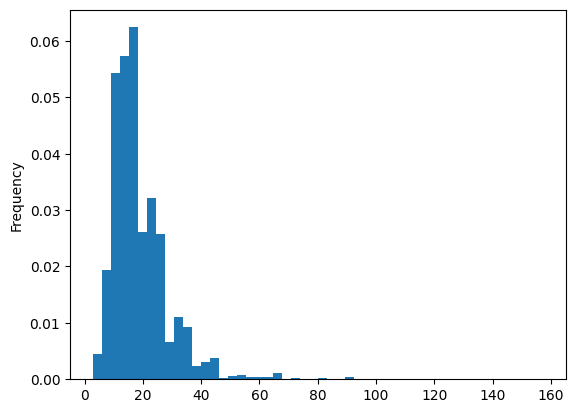

In [ ]:
#train['income_total'] = train['income_total'].astype(object)
#train['income_total'] = train['income_total']/10000
#test['income_total'] = test['income_total']/10000
##############################################################3
#print(train['income_total'].value_counts(bins=10,sort=False))
#train['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
#count, bin_dividers =np.histogram(train['income_total'], bins=7)
#bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
#train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
#test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [ ]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,1,1,0,0,11.630726,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,0,0,1,0,2.0,-60.0
1,0,0,1,0,11.813045,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,2.0,-36.0
2,0,0,1,0,11.147267,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,2.0,-40.0
3,1,1,0,0,11.630726,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,2.0,-41.0
4,0,1,1,0,12.323865,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,12.218505,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,0,2.0,-19.0
9996,1,1,1,0,12.218505,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,0,0,2.0,-34.0
9997,0,0,1,0,12.586227,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,0,0,0,2.0,-55.0
9998,0,1,0,0,12.100723,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,0,1,0,2.0,-33.0


### 레이블 인코딩

In [ ]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

### 음수 데이터를 양수로 바꾸기

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [ ]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,145,0,1,1,2,3,1,0,0,0,2.0,0,1.0
1,0,0,1,1,165,0,4,0,1,2,0,0,0,1,3.0,0,1.0
2,1,1,1,0,214,4,1,1,1,6,1,0,1,0,2.0,1,2.0
3,0,0,1,0,145,0,4,1,1,4,0,0,1,0,2.0,2,0.0
4,0,1,1,0,111,2,1,1,1,4,0,0,0,0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,0,0,0,2,156,2,4,1,1,2,0,0,0,0,4.0,0,1.0
26447,0,0,1,1,133,4,1,2,1,4,0,0,0,0,2.0,3,2.0
26448,0,1,0,0,181,4,4,0,5,1,0,0,0,0,2.0,1,2.0
26449,1,0,1,0,121,4,2,3,1,1,0,0,0,0,1.0,3,2.0


In [ ]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,1,1,0,0,61,1,4,0,1,8,0,0,1,0,2.0,3
1,0,0,1,0,82,2,1,1,1,6,3,0,1,0,2.0,2
2,0,0,1,0,34,4,4,1,1,4,0,1,1,0,2.0,2
3,1,1,0,0,61,0,4,1,1,6,0,1,0,0,2.0,2
4,0,1,1,0,130,2,1,1,1,5,3,1,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,121,4,2,1,1,6,2,1,1,0,2.0,1
9996,1,1,1,0,121,4,4,0,1,1,0,1,0,0,2.0,2
9997,0,0,1,0,152,4,4,1,1,7,5,0,0,0,2.0,3
9998,0,1,0,0,112,0,4,1,1,5,0,0,1,0,2.0,2


In [ ]:
train.shape

(26451, 17)

In [ ]:
test.shape

(10000, 16)

# **[데이터 모델링]**

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26451, 16) (26451, 1) (10000, 16)


## XGBoost 로 모델링하기
### K-Fold

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [ ]:
#객체 생성
model = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=4, random_state = 32)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(model):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        model.fit(X_train, y_train)

        predictions=model.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=model.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(model)

FOLD 0 : logloss:0.8281083246203869
FOLD 1 : logloss:0.8361546675960677
FOLD 2 : logloss:0.8297319808848765
FOLD 3 : logloss:0.8200569564907562
FOLD 4 : logloss:0.8230387307104933
Mean:0.8274181320605161


In [ ]:
my_submission

array([[0.09301281, 0.06728206, 0.83970516],
       [0.14826894, 0.04551864, 0.80621244],
       [0.12122647, 0.16213221, 0.71664131],
       ...,
       [0.01405946, 0.03323857, 0.95270195],
       [0.14138324, 0.23502682, 0.62358992],
       [0.06636874, 0.26495797, 0.66867328]])

In [ ]:
submission

,index,0,1,2
0,26457,0.093013,0.067282,0.839705
1,26458,0.148269,0.045519,0.806212
2,26459,0.121226,0.162132,0.716641
3,26460,0.223652,0.142031,0.634317
4,26461,0.326364,0.274776,0.398860
...,...,...,...,...
9995,36452,0.129475,0.261198,0.609327
9996,36453,0.108928,0.240567,0.650505
9997,36454,0.014059,0.033239,0.952702
9998,36455,0.141383,0.235027,0.623590


In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.093013,0.067282,0.839705
1,26458,0.148269,0.045519,0.806212
2,26459,0.121226,0.162132,0.716641
3,26460,0.223652,0.142031,0.634317
4,26461,0.326364,0.274776,0.398860
...,...,...,...,...
9995,36452,0.129475,0.261198,0.609327
9996,36453,0.108928,0.240567,0.650505
9997,36454,0.014059,0.033239,0.952702
9998,36455,0.141383,0.235027,0.623590


In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/credit_card/open/submission.csv', index=False)